# A quick guide for using this repository

This notebook includes the example uses of the 3 algorithms that have been implemented, using a subset of the popular CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html).

The purpose of this notebook is just to explain some of the functions that have been used in the algorithms. More fluent workflows can be found in the `algorithm_codes` folder.

## Import the necessary libraries

In [1]:
import numpy as np
from utils import *
import torchvision
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, 'algorithm_codes')
from multiclass_adaboost import *
from multiclass_logitboost import *
from multiclass_kernel_svm import *
from sklearn.metrics import accuracy_score

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


## You can set `download=True` for PyTorch to download the dataset for you if you don't have it already in the directory. However, it is recommended to download it externally as the speed can be extremely slow using PyTorch.

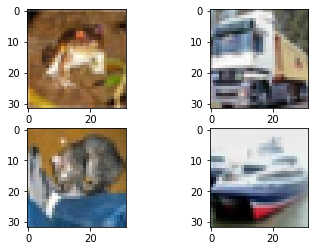

In [2]:
# set directory for PyTorch to locate the dataset
data_dir = 'Datasets'
trainset = torchvision.datasets.CIFAR10(root=data_dir)
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False)

# show the first few images of the dataset
plt.figure()

plt.subplot(2, 2, 1)
plt.imshow(trainset.data[0])

plt.subplot(2, 2, 2)
plt.imshow(trainset.data[1])

plt.subplot(2, 2, 3)
plt.imshow(testset.data[0])

plt.subplot(2, 2, 4)
plt.imshow(testset.data[1])

## Control the size of the training and testing set. Set this to however big you want, or just leave it as `len(trainset)` and `len(testset)` to use the whole dataset. We are only using a very small number here to speed up the training and testing process.

In [3]:
train_sample_size = 80
test_sample_size = 20

## The data contains colored images, so in order to work with them, we have to convert them to grayscale images

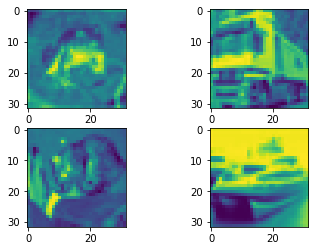

In [4]:
train_data = np.dot(np.array(trainset.data)[...,:3], [0.299 , 0.587, 0.114])
train_y = np.array(trainset.targets)[:train_sample_size]
test_data = np.dot(np.array(testset.data)[...,:3], [0.299 , 0.587, 0.114])
test_y = np.array(testset.targets)[:test_sample_size]

# show the first few images after conversion
plt.figure()

plt.subplot(2, 2, 1)
plt.imshow(train_data[0])

plt.subplot(2, 2, 2)
plt.imshow(train_data[1])

plt.subplot(2, 2, 3)
plt.imshow(test_data[0])

plt.subplot(2, 2, 4)
plt.imshow(test_data[1])

## Sub-region sampling

To increase the number of samples, a subsampling strategy is used for each training image. So instead of using the whole image, we sample multiple sub-regions of the image and use those sub-images as training data.

The effect can be seen below, where the top-left corner of the plot shows the original image, and the other plots depict the sub-regions that were sampled.

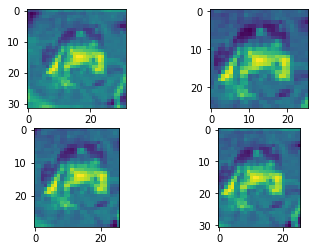

In [5]:
sub_regions_list = generate_sub_regions_random(3, 32, 32, 1.25, 1.25)
sub_ims = []
im = train_data[0]
for j in range(len(sub_regions_list)):
    x_j, y_j, w_j, h_j = sub_regions_list[j]
    sub_im = im[ y_j : y_j+h_j, x_j : x_j+w_j ]
    sub_ims.append(sub_im)
    
plt.figure()

plt.subplot(2, 2, 1)
plt.imshow(im)

plt.subplot(2, 2, 2)
plt.imshow(sub_ims[0])

plt.subplot(2, 2, 3)
plt.imshow(sub_ims[1])

plt.subplot(2, 2, 4)
plt.imshow(sub_ims[2])

__NOTE__: The pre-processing and ML steps below are acting on the whole image. Sub-region sampling is only used for demonstration purposes here, its real usage can be found in the code.

## Pre-populate the training and testing arrays. Here we use different arrays for the Euclidean and Riemannian case.

In [6]:
train_X_cov = np.zeros((train_sample_size, 8, 8))
test_X_cov = np.zeros((test_sample_size, 8, 8))
train_X = np.zeros((train_sample_size, 36))
test_X = np.zeros((test_sample_size, 36))

## Now we process training and testing sets separately.

In [7]:
# Process training samples
for i in range(train_sample_size):
    im  = train_data[i, :, :]
    
    # convert to 8D covariance descriptors
    im_features = compute_eight_dimensional_feature(im)
    w, h, d = im_features.shape
    
    # compute covariance matrix from the descriptors
    cov_matrix = np.cov(im_features.reshape(w*h, d).T)    
    train_X_cov[i, :, :] = cov_matrix
    
    # flatten the matrix for the Euclidean case
    train_X[i, :] = vech(cov_matrix)

In [8]:
# Process testing samples
for i in range(test_sample_size):
    im = test_data[i, :, :]
    
    # convert to 8D covariance descriptors
    im_features = compute_eight_dimensional_feature(im)
    w, h, d = im_features.shape
    
    # compute covariance matrix from the descriptors
    cov_matrix = np.cov(im_features.reshape(w*h, d).T)
    test_X_cov[i, :, :] = cov_matrix
    
    # flatten the matrix for the Euclidean case
    test_X[i, :] = vech(cov_matrix)

## With the training and testing data ready, we can run any of the 3 algorithms we want on this dataset.

NOTE: The conversion of data should only happen once using the scripts in the `data_preprocessing` folder, after which they can be used as much as necessary in the algorithms.

### Multiclass Adaboost

In [9]:
score_cov = multiclass_adaboost_cov(train_X_cov, train_y, test_X_cov, test_y, [10], 2)
score = multiclass_adaboost(train_X, train_y, test_X, test_y, [10], 2)

print("Accuracy of Riemannian case =", score_cov)
print("Accuracy of Euclidean case =", score)

Accuracy of Riemannian case = [0.15]
Accuracy of Euclidean case = [0.05]


### Multiclass Logitboost

In [10]:
score_cov = multiclass_logitboost_cov(train_X_cov, train_y, test_X_cov, test_y, [10], 2)
score = multiclass_logitboost(train_X, train_y, test_X, test_y, [10], 2)

print("Accuracy of Riemannian case =", score_cov)
print("Accuracy of Euclidean case =", score)

Accuracy of Riemannian case = [0.1]
Accuracy of Euclidean case = [0.2]


### Multiclass kernel SVM

In [11]:
print("Accuracy of Riemannian case =", \
      multiclass_kernel_SVM(train_X_cov, train_y, test_X_cov, test_y, 'R'))
print("Accuracy of Euclidean case =", \
      multiclass_kernel_SVM(train_X, train_y, test_X, test_y, 'E'))

Accuracy of Riemannian case = 0.3
Accuracy of Euclidean case = 0.2


## And this is the end of this tutorial!